In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage

**CreatetheDatasets**

In [ ]:
def loadIndianPinesData():
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive/AI data/paviaU')
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train


def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize, wasPCAapplied = True, numPCAComponents = 0, testRatio = 0.25):
    if wasPCAapplied:
        with open("X_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("X_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("y_trainPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("y_testPatches_" + str(windowSize) + "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open("../preprocessedData/XtrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("../preprocessedData/XtestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("../preprocessedData/ytrainWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("../preprocessedData/ytestWindowSize" + str(windowSize) + ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            

In [ ]:
# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt
myFile = open('/content/drive/MyDrive/Colab Notebooks/HSI-Classification/CNN to HSI Classification/global_variables.txt', 'r') 
file = myFile.readlines()[:]


for line in file:

    if line[0:3] == "win":

        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":

        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:

        ds = line.find('=')
        testRatio = float(line[ds+1:])

In [ ]:
#加载数据
print("加载数据")
X, y = loadIndianPinesData()
print("hyperspectral data shape:", X.shape)
print("label data shape:", y.shape)
#主成分降维
print("主成分降维")
X = applyPCA(X,numPCAcomponents)
print("hypercpectral data shape after pca:", X.shape)
#创建数据块
print("创建数据块")
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
print("Xpatches shape:", XPatches.shape)
print("yPatches shpae:", yPatches.shape)
#划分数据集
print("划分数据集")
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
#数据增强
print("数据增强")
X_train = AugmentData(X_train)
print("X_tarin shape after augment:", X_train.shape)
# 为了适应 pytorch 结构，数据要做 transpose
print("数据transpose")
X_train = X_train.transpose(0, 3, 2, 1)
X_test  = X_test.transpose(0, 3, 2, 1)
print('after transpose: X_train shape: ', X_train.shape) 
print('after transpose: X_test  shape: ', X_test.shape) 

加载数据
hyperspectral data shape: (145, 145, 200)
label data shape: (145, 145)
主成分降维
hypercpectral data shape after pca: (145, 145, 30)
创建数据块
Xpatches shape: (10249, 5, 5, 30)
yPatches shpae: (10249,)
划分数据集
X_train shape: (7686, 5, 5, 30)
X_test shape: (2563, 5, 5, 30)
y_train shape: (7686,)
y_test shape: (2563,)
数据增强
X_tarin shape after augment: (7686, 5, 5, 30)
数据transpose
after transpose: X_train shape:  (7686, 30, 5, 5)
after transpose: X_test  shape:  (2563, 30, 5, 5)


In [ ]:
import torch
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = X_train.shape[0]
        self.x_data = torch.FloatTensor(X_train)
        self.y_data = torch.LongTensor(y_train)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = X_test.shape[0]
        self.x_data = torch.FloatTensor(X_test)
        self.y_data = torch.LongTensor(y_test)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=32, shuffle=False, num_workers=2)

**TrainTheModel**

In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 7.4 MB/s 


In [ ]:
import torchvision
from torch.torch_version import TorchVersion
import torch
from torch.nn import Conv2d,MaxPool2d,Flatten,Sequential,Dropout
from torch.utils.data import DataLoader,Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from scipy.io import loadmat
import math

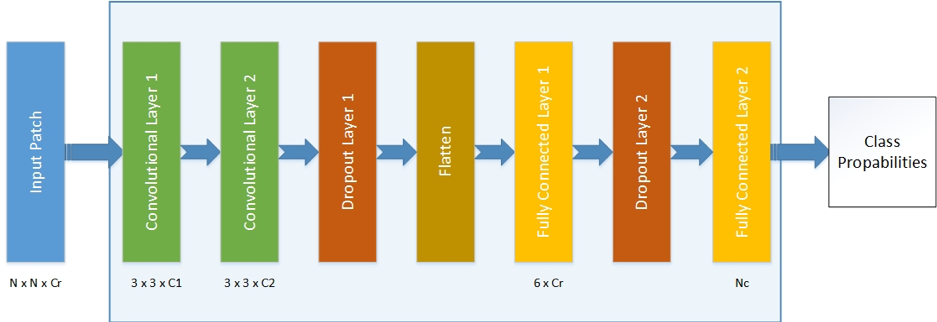

In [ ]:
import torch
from torch.nn import Conv2d,MaxPool2d,Flatten

class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = Conv2d(in_channels=30,out_channels=90,kernel_size=3)
    self.conv2 = Conv2d(in_channels=90,out_channels=270,kernel_size=3)
    self.dropout = Dropout(0.25)
    self.fla = Flatten()
    self.fc1 = torch.nn.Linear(270,180)
    self.dropout2 = Dropout(0.5)
    self.fc2 = torch.nn.Linear(180,16)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.dropout(x)
    x = self.fla(x)
    x = self.fc1(x)
    x = self.dropout2(x)
    x = self.fc2(x)

    return x
model = Net()
print(model)
input = torch.ones((599,30,5,5))
outputs = model(input)
print(outputs.shape)

Net(
  (conv1): Conv2d(30, 90, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(90, 270, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fla): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=270, out_features=180, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=180, out_features=16, bias=True)
)
torch.Size([599, 16])


In [ ]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(100):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his

In [ ]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(y_test, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [ ]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = Net().to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

[Epoch: 1]   [loss avg: 207.3902]   [current loss: 0.3947]  [current acc: 0.7972]
[Epoch: 2]   [loss avg: 176.8278]   [current loss: 0.3485]  [current acc: 0.8249]
[Epoch: 3]   [loss avg: 162.9425]   [current loss: 0.1584]  [current acc: 0.7958]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 4]   [loss avg: 153.5332]   [current loss: 0.1805]  [current acc: 0.8392]
[Epoch: 5]   [loss avg: 148.1329]   [current loss: 0.1997]  [current acc: 0.8050]
[Epoch: 6]   [loss avg: 144.4770]   [current loss: 0.0480]  [current acc: 0.8249]
[Epoch: 7]   [loss avg: 141.0787]   [current loss: 1.6799]  [current acc: 0.8160]
[Epoch: 8]   [loss avg: 138.8283]   [current loss: 0.1748]  [current acc: 0.8202]
[Epoch: 9]   [loss avg: 136.6615]   [current loss: 0.4852]  [current acc: 0.8368]
[Epoch: 10]   [loss avg: 135.4001]   [current loss: 0.1995]  [current acc: 0.8244]
[Epoch: 11]   [loss avg: 133.9076]   [current loss: 0.2355]  [current acc: 0.7988]
[Epoch: 12]   [loss avg: 132.4154]   [current loss: 0.0471]  [current acc: 0.8175]
[Epoch: 13]   [loss avg: 131.1577]   [current loss: 0.0898]  [current acc: 0.8281]
[Epoch: 14]   [loss avg: 130.7160]   [current loss: 0.0619]  [current acc: 0.8181]
[Epoch: 15]   [loss avg: 129.2415]   [current loss: 0.0004]  [current acc: 0.8160]
[Epoch: 16

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 21]   [loss avg: 125.0698]   [current loss: 1.1079]  [current acc: 0.8026]
[Epoch: 22]   [loss avg: 124.7495]   [current loss: 0.0012]  [current acc: 0.8222]
[Epoch: 23]   [loss avg: 123.8019]   [current loss: 0.1957]  [current acc: 0.8226]
[Epoch: 24]   [loss avg: 123.3815]   [current loss: 1.1257]  [current acc: 0.8170]
[Epoch: 25]   [loss avg: 123.0071]   [current loss: 0.0134]  [current acc: 0.8206]
[Epoch: 26]   [loss avg: 122.3626]   [current loss: 0.5212]  [current acc: 0.8328]
[Epoch: 27]   [loss avg: 121.9594]   [current loss: 0.2091]  [current acc: 0.8190]
[Epoch: 28]   [loss avg: 121.4184]   [current loss: 2.0656]  [current acc: 0.8176]
[Epoch: 29]   [loss avg: 121.1529]   [current loss: 0.4083]  [current acc: 0.8161]
[Epoch: 30]   [loss avg: 121.1866]   [current loss: 0.6139]  [current acc: 0.8289]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 31]   [loss avg: 121.1645]   [current loss: 0.0283]  [current acc: 0.8192]
[Epoch: 32]   [loss avg: 121.0787]   [current loss: 0.0959]  [current acc: 0.8158]
[Epoch: 33]   [loss avg: 120.6810]   [current loss: 0.8282]  [current acc: 0.8214]
[Epoch: 34]   [loss avg: 120.6938]   [current loss: 0.2374]  [current acc: 0.8119]
[Epoch: 35]   [loss avg: 120.4551]   [current loss: 1.4749]  [current acc: 0.8347]
[Epoch: 36]   [loss avg: 120.4119]   [current loss: 0.2306]  [current acc: 0.8364]
[Epoch: 37]   [loss avg: 120.0054]   [current loss: 0.3262]  [current acc: 0.8098]
[Epoch: 38]   [loss avg: 119.5779]   [current loss: 0.0133]  [current acc: 0.8226]
[Epoch: 39]   [loss avg: 119.1532]   [current loss: 0.2901]  [current acc: 0.8233]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 40]   [loss avg: 118.7910]   [current loss: 0.3077]  [current acc: 0.8232]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 41]   [loss avg: 118.8813]   [current loss: 4.8378]  [current acc: 0.8365]
[Epoch: 42]   [loss avg: 119.1051]   [current loss: 0.2481]  [current acc: 0.8361]
[Epoch: 43]   [loss avg: 119.3312]   [current loss: 0.5299]  [current acc: 0.8223]
[Epoch: 44]   [loss avg: 119.0678]   [current loss: 0.5305]  [current acc: 0.8247]
[Epoch: 45]   [loss avg: 118.8046]   [current loss: 0.2584]  [current acc: 0.8224]
[Epoch: 46]   [loss avg: 118.8003]   [current loss: 0.6570]  [current acc: 0.8195]
[Epoch: 47]   [loss avg: 118.5953]   [current loss: 1.2069]  [current acc: 0.8194]
[Epoch: 48]   [loss avg: 118.5731]   [current loss: 0.6871]  [current acc: 0.8209]
[Epoch: 49]   [loss avg: 118.4214]   [current loss: 0.1223]  [current acc: 0.8253]
[Epoch: 50]   [loss avg: 118.1165]   [current loss: 0.0286]  [current acc: 0.8222]
[Epoch: 51]   [loss avg: 118.0142]   [current loss: 0.3326]  [current acc: 0.8214]
[Epoch: 52]   [loss avg: 118.0464]   [current loss: 0.0065]  [current acc: 0.8097]
[Epo

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 61]   [loss avg: 117.3436]   [current loss: 1.0574]  [current acc: 0.8337]
[Epoch: 62]   [loss avg: 117.2747]   [current loss: 0.0970]  [current acc: 0.8252]
[Epoch: 63]   [loss avg: 117.3231]   [current loss: 0.1983]  [current acc: 0.8168]
[Epoch: 64]   [loss avg: 117.3990]   [current loss: 1.8956]  [current acc: 0.8247]
[Epoch: 65]   [loss avg: 117.4164]   [current loss: 0.5820]  [current acc: 0.8218]
[Epoch: 66]   [loss avg: 117.3090]   [current loss: 0.2278]  [current acc: 0.8264]
[Epoch: 67]   [loss avg: 117.2332]   [current loss: 0.5922]  [current acc: 0.8172]
[Epoch: 68]   [loss avg: 117.0972]   [current loss: 2.0894]  [current acc: 0.8185]
[Epoch: 69]   [loss avg: 117.2816]   [current loss: 1.6672]  [current acc: 0.8277]
[Epoch: 70]   [loss avg: 117.3748]   [current loss: 3.0149]  [current acc: 0.8204]
[Epoch: 71]   [loss avg: 117.4570]   [current loss: 0.0104]  [current acc: 0.8178]
[Epoch: 72]   [loss avg: 117.4938]   [current loss: 0.5514]  [current acc: 0.8350]
[Epo

In [ ]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(y_test, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     0.8462    1.0000    0.9167        11
         1.0     0.7629    0.7479    0.7553       357
         2.0     0.8563    0.7163    0.7801       208
         3.0     0.8400    0.7119    0.7706        59
         4.0     0.9576    0.9339    0.9456       121
         5.0     0.9385    1.0000    0.9683       183
         6.0     1.0000    0.5714    0.7273         7
         7.0     0.9835    0.9917    0.9876       120
         8.0     1.0000    0.6000    0.7500         5
         9.0     0.7523    0.6749    0.7115       243
        10.0     0.7458    0.8648    0.8009       614
        11.0     0.8385    0.7365    0.7842       148
        12.0     1.0000    0.9804    0.9901        51
        13.0     0.9480    0.9810    0.9642       316
        14.0     0.9221    0.7320    0.8161        97
        15.0     1.0000    0.9130    0.9545        23

    accuracy                         0.8377      2563
   macro avg     0.8995   

In [ ]:
# load the original image
X = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]
patch_size=5
X = applyPCA(X, numComponents=30)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            #print(image_patch.shape)
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2])
            #print(image_patch.shape)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 1 == 0:
        print('... ... row ', i, ' handling ... ...')

... ... row  0  handling ... ...
... ... row  1  handling ... ...
... ... row  2  handling ... ...
... ... row  3  handling ... ...
... ... row  4  handling ... ...
... ... row  5  handling ... ...
... ... row  6  handling ... ...
... ... row  7  handling ... ...
... ... row  8  handling ... ...
... ... row  9  handling ... ...
... ... row  10  handling ... ...
... ... row  11  handling ... ...
... ... row  12  handling ... ...
... ... row  13  handling ... ...
... ... row  14  handling ... ...
... ... row  15  handling ... ...
... ... row  16  handling ... ...
... ... row  17  handling ... ...
... ... row  18  handling ... ...
... ... row  19  handling ... ...
... ... row  20  handling ... ...
... ... row  21  handling ... ...
... ... row  22  handling ... ...
... ... row  23  handling ... ...
... ... row  24  handling ... ...
... ... row  25  handling ... ...
... ... row  26  handling ... ...
... ... row  27  handling ... ...
... ... row  28  handling ... ...
... ... row  29  handlin

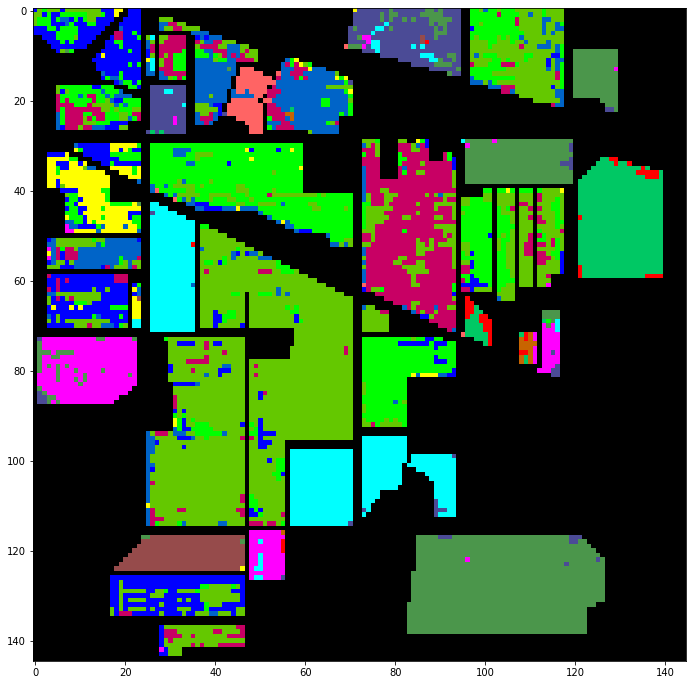

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(12,12))